# Preperations & multimodel functions

## Imports % data preperations

In [238]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import time

In [239]:
# Define compute device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# set seed for reproducibility
torch.manual_seed(42)

Using cuda device


### Dataset

In [240]:
# download cifar10 dataset
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [241]:
# Create data loaders as baseline for the models - might be changed for later models
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## General functions

In [242]:
# Training loop
def train(dataloader, model, loss_function, optimizer, epochs):
    loss_values = []
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        size = len(dataloader.dataset)
        total_loss = 0
        correct = 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Compute prediction error
            pred = model(X)
            loss = loss_function(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log the loss and accuracy
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / size
        loss_values.append(avg_loss)
        print(f"Loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%")
        
    return loss_values
        

In [243]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    
    accuracy = 100 * correct
    avg_loss = test_loss
    
    return accuracy, avg_loss

In [244]:
def plot_loss(loss_values):
    plt.plot(loss_values, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [245]:
def seconds_to_minutes(seconds):
    m = seconds / 60
    s = seconds % 60
    time = f'{m} minutes and {s} seconds'
    return time

In [246]:
def print_time_taken(start_time, current_time):
    elapsed_time = current_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Time taken: {minutes} minutes and {seconds} seconds")

In [253]:
def run_experiment(model, learning_rate=1e-3, epochs=100, optimizer_name='adam',weight_decay=None, momentum=None, save_path=None):
    start_time = time.time()
    model = model.to(device)
    
    # Set the optimizer parameters if specified in the function call
    optimizer_params = {'lr': learning_rate}
    if weight_decay:
        optimizer_params['weight_decay'] = weight_decay
    
    # Initialize the optimizer based on the optimizer name
    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
        
    elif optimizer_name.lower() == 'sgd':
        if momentum: # Check if momentum is specified only for SGD
            optimizer_params['momentum'] = momentum
        optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
    else:
        raise ValueError("Invalid optimizer name")
    
    # Initialize the loss function
    loss_function = nn.CrossEntropyLoss()
    
    loss_values = train(train_dataloader, model, loss_function, optimizer, epochs)
    
    test_accuracy, test_loss = test(test_dataloader, model, loss_function)
    
    #print(f"Time taken: {seconds_to_minutes(time - start_time())}")
    print_time_taken(start_time, time.time())
    
    print("Test results:")
    
    print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")
    
    plot_loss(loss_values)
    
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved PyTorch Model State to {save_path}")
    

# Models
## Base Model
I'm planning to first demonstrate the inefficiency of a fully connected model compared to a CNN on the CIFAR10 dataset.

### Model architecture:

In [248]:
class base_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
run_experiment(base_model(), learning_rate=1e-3, epochs=40, optimizer_name='sgd', save_path="base_model.pth")

Epoch 1
-------------------------------
Loss: 2.293890, Accuracy: 13.1%
Epoch 2
-------------------------------
Loss: 2.278608, Accuracy: 17.2%
Epoch 3
-------------------------------
Loss: 2.264688, Accuracy: 19.0%
Epoch 4
-------------------------------
Loss: 2.249558, Accuracy: 19.6%
Epoch 5
-------------------------------
Loss: 2.231957, Accuracy: 20.4%
Epoch 6
-------------------------------
Loss: 2.211105, Accuracy: 21.4%
Epoch 7
-------------------------------
Loss: 2.187011, Accuracy: 22.4%
Epoch 8
-------------------------------
Loss: 2.159844, Accuracy: 23.4%
Epoch 9
-------------------------------
Loss: 2.130179, Accuracy: 24.7%
Epoch 10
-------------------------------
Loss: 2.101007, Accuracy: 25.9%
Epoch 11
-------------------------------
Loss: 2.074609, Accuracy: 26.7%
Epoch 12
-------------------------------
Loss: 2.051406, Accuracy: 27.3%
Epoch 13
-------------------------------
Loss: 2.031305, Accuracy: 27.9%
Epoch 14
-------------------------------
Loss: 2.013890, Acc

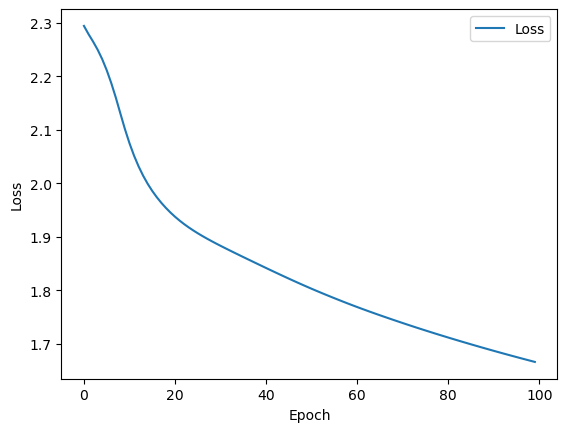

Saved PyTorch Model State to base_model.pth


In [254]:
run_experiment(base_model(), learning_rate=1e-3, epochs=100, optimizer_name='sgd', save_path="base_model.pth")

## Convolutional Neural Network
Below is a simple CNN model that I will use to demonstrate the power of CNNs on the CIFAR10 dataset.
This CNN has roughly the same number of parameters and complexity as the base model.

### Parameter count:
#### convoluted model

conv1: 3 x 12 x 3 x 3 + 12 = 336

conv2: 12 x 12 x 3 x 3 + 12 = 1308

fc1: 3072 x 64 + 64 = 196672

fc2: 64 x 10 + 10 = 650

total parameters: 336 + 1308 + 196672 + 650 = 198,966 ~ 200k

#### base model

fc1: 3 * 32* 32 * 64 + 64 = 196,672

fc2: 64 * 64 + 64 = 4,160

fc3: 64 * 10 + 10 = 650

total parameters: 196672 + 4160 + 650 = 201,482 ~ 200k



In [255]:
class base_conv_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Two small convolutional layers, each with 12 output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, padding=1)
        
        # Pool to reduce spatial dimension from 32x32 to 16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten before feeding into linear layers
        self.flatten = nn.Flatten()
        
        # After the pool layer, the spatial dimension is 16x16 and we have 12 channels
        # --> 12 * 16 * 16 = 3072
        self.fc1 = nn.Linear(12 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
        
        # Non-linear activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolution + ReLU
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        
        # Pooling
        x = self.pool(x)
        
        # Flatten to [batch_size, 12*16*16]
        x = self.flatten(x)
        
        # Final fully-connected layers + ReLU in between
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

Epoch 1
-------------------------------
Loss: 2.303888, Accuracy: 10.0%
Epoch 2
-------------------------------
Loss: 2.303237, Accuracy: 10.0%
Epoch 3
-------------------------------
Loss: 2.302765, Accuracy: 10.1%
Epoch 4
-------------------------------
Loss: 2.302409, Accuracy: 10.3%
Epoch 5
-------------------------------
Loss: 2.302076, Accuracy: 10.5%
Epoch 6
-------------------------------
Loss: 2.301738, Accuracy: 10.5%
Epoch 7
-------------------------------
Loss: 2.301376, Accuracy: 10.4%
Epoch 8
-------------------------------
Loss: 2.300977, Accuracy: 11.6%
Epoch 9
-------------------------------
Loss: 2.300522, Accuracy: 13.8%
Epoch 10
-------------------------------
Loss: 2.299989, Accuracy: 15.8%
Epoch 11
-------------------------------
Loss: 2.299349, Accuracy: 15.9%
Epoch 12
-------------------------------
Loss: 2.298557, Accuracy: 15.1%
Epoch 13
-------------------------------
Loss: 2.297555, Accuracy: 14.4%
Epoch 14
-------------------------------
Loss: 2.296269, Acc

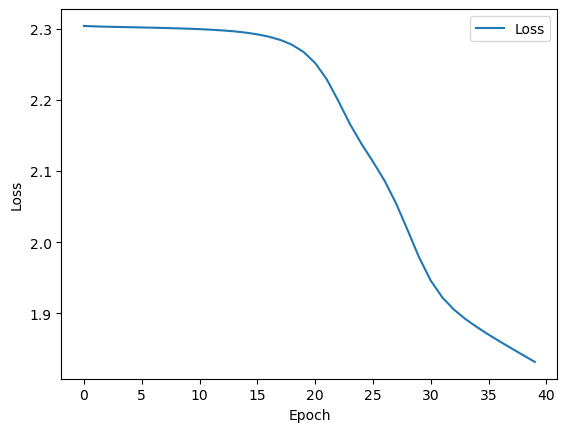

Saved PyTorch Model State to base_conv_model.pth


In [251]:
run_experiment(base_conv_model(), learning_rate=1e-3, epochs=40, optimizer_name='sgd', save_path="base_conv_model.pth")

Epoch 1
-------------------------------
Loss: 2.303428, Accuracy: 11.5%
Epoch 2
-------------------------------
Loss: 2.299700, Accuracy: 10.3%
Epoch 3
-------------------------------
Loss: 2.296174, Accuracy: 10.0%
Epoch 4
-------------------------------
Loss: 2.292136, Accuracy: 10.0%
Epoch 5
-------------------------------
Loss: 2.287188, Accuracy: 10.3%
Epoch 6
-------------------------------
Loss: 2.280770, Accuracy: 11.4%
Epoch 7
-------------------------------
Loss: 2.272033, Accuracy: 12.7%
Epoch 8
-------------------------------
Loss: 2.259519, Accuracy: 14.0%
Epoch 9
-------------------------------
Loss: 2.241156, Accuracy: 15.9%
Epoch 10
-------------------------------
Loss: 2.216052, Accuracy: 18.1%
Epoch 11
-------------------------------
Loss: 2.186873, Accuracy: 20.1%
Epoch 12
-------------------------------
Loss: 2.158855, Accuracy: 21.6%
Epoch 13
-------------------------------
Loss: 2.134957, Accuracy: 22.8%
Epoch 14
-------------------------------
Loss: 2.114164, Acc

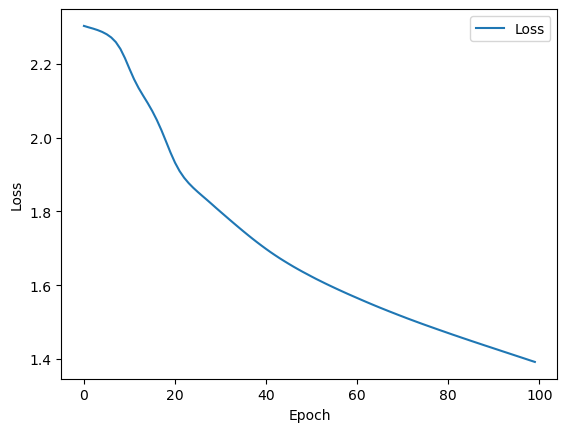

Saved PyTorch Model State to base_conv_model_100.pth


In [256]:
run_experiment(base_conv_model(), learning_rate=1e-3, epochs=100, optimizer_name='sgd', save_path="base_conv_model_100.pth")

### Now for the same model but using adam optimizer

Epoch 1
-------------------------------
Loss: 1.714909, Accuracy: 38.7%
Epoch 2
-------------------------------
Loss: 1.437625, Accuracy: 48.6%
Epoch 3
-------------------------------
Loss: 1.319931, Accuracy: 53.2%
Epoch 4
-------------------------------
Loss: 1.207586, Accuracy: 57.4%
Epoch 5
-------------------------------
Loss: 1.121465, Accuracy: 60.5%
Epoch 6
-------------------------------
Loss: 1.057626, Accuracy: 62.8%
Epoch 7
-------------------------------
Loss: 1.005833, Accuracy: 64.7%
Epoch 8
-------------------------------
Loss: 0.960968, Accuracy: 66.3%
Epoch 9
-------------------------------
Loss: 0.921614, Accuracy: 67.7%
Epoch 10
-------------------------------
Loss: 0.886073, Accuracy: 68.9%
Epoch 11
-------------------------------
Loss: 0.854060, Accuracy: 70.2%
Epoch 12
-------------------------------
Loss: 0.826250, Accuracy: 71.1%
Epoch 13
-------------------------------
Loss: 0.799772, Accuracy: 72.0%
Epoch 14
-------------------------------
Loss: 0.775341, Acc

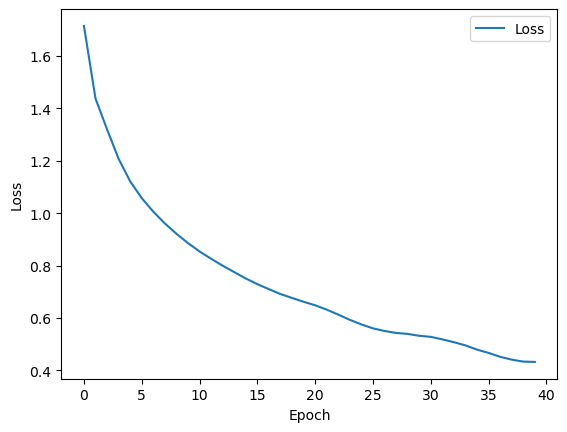

Saved PyTorch Model State to base_conv_model_adam.pth


In [257]:
run_experiment(base_conv_model(), learning_rate=1e-3, epochs=40, optimizer_name='adam', save_path="base_conv_model_adam.pth")

Epoch 1
-------------------------------
Loss: 1.734604, Accuracy: 37.2%
Epoch 2
-------------------------------
Loss: 1.370239, Accuracy: 51.0%
Epoch 3
-------------------------------
Loss: 1.246478, Accuracy: 55.6%
Epoch 4
-------------------------------
Loss: 1.162833, Accuracy: 58.8%
Epoch 5
-------------------------------
Loss: 1.096407, Accuracy: 61.3%
Epoch 6
-------------------------------
Loss: 1.038614, Accuracy: 63.4%
Epoch 7
-------------------------------
Loss: 0.988141, Accuracy: 65.2%
Epoch 8
-------------------------------
Loss: 0.944553, Accuracy: 66.7%
Epoch 9
-------------------------------
Loss: 0.908252, Accuracy: 68.1%
Epoch 10
-------------------------------
Loss: 0.877382, Accuracy: 69.2%
Epoch 11
-------------------------------
Loss: 0.849247, Accuracy: 70.2%
Epoch 12
-------------------------------
Loss: 0.824182, Accuracy: 71.1%
Epoch 13
-------------------------------
Loss: 0.801165, Accuracy: 72.0%
Epoch 14
-------------------------------
Loss: 0.780066, Acc

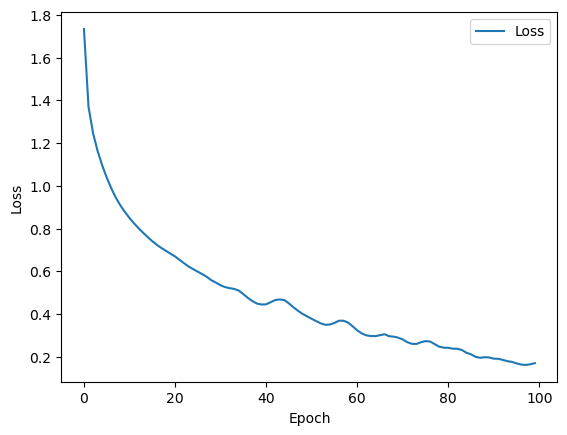

Saved PyTorch Model State to base_conv_model_adam_100.pth


In [259]:
run_experiment(base_conv_model(), learning_rate=1e-3, epochs=100, optimizer_name='adam', save_path="base_conv_model_adam_100.pth")

As we can see, the CNN model with adam optimizer performs much better on the training set, but has higher bias which suggest we need to add regularization to the model if we stick with adam optimizer.
After researching, I found that the CIFAR-10 dataset has alot of success with SGD with momentum - so I might switch to it on a later stage.

## Improving the CNN
Now we will improve the CNN by introducing batch normalization and pooling, and add dropout layer to prevent overfiting.

In [260]:
class improved_conv_model(nn.Module):
    def __init__(self, droput_prob=0.3):
        super().__init__()
            
        # Adding another convolutional layer and increasing the number of output channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        
        # Pooling layer to reduce spatial dimension from 32x32 to 16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
        
        self.relu = nn.ReLU()
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=droput_prob)

    def forward(self, x):
        # Convolution + ReLU
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        
        # Pooling
        x = self.pool(x)
        # Flattening
        x = self.flatten(x)
        
        # Final fully-connected layers + ReLU in between
        x = self.relu(self.fc1(x))
        
        # Dropout layer
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

Epoch 1
-------------------------------
Loss: 1.722964, Accuracy: 35.3%
Epoch 2
-------------------------------
Loss: 1.471320, Accuracy: 44.7%
Epoch 3
-------------------------------
Loss: 1.386245, Accuracy: 48.2%
Epoch 4
-------------------------------
Loss: 1.336769, Accuracy: 49.8%
Epoch 5
-------------------------------
Loss: 1.305091, Accuracy: 51.0%
Epoch 6
-------------------------------
Loss: 1.279123, Accuracy: 51.8%
Epoch 7
-------------------------------
Loss: 1.249811, Accuracy: 53.5%
Epoch 8
-------------------------------
Loss: 1.229086, Accuracy: 53.9%
Epoch 9
-------------------------------
Loss: 1.203683, Accuracy: 55.2%
Epoch 10
-------------------------------
Loss: 1.185091, Accuracy: 55.7%
Epoch 11
-------------------------------
Loss: 1.154266, Accuracy: 57.1%
Epoch 12
-------------------------------
Loss: 1.149825, Accuracy: 57.3%
Epoch 13
-------------------------------
Loss: 1.131843, Accuracy: 57.9%
Epoch 14
-------------------------------
Loss: 1.104498, Acc

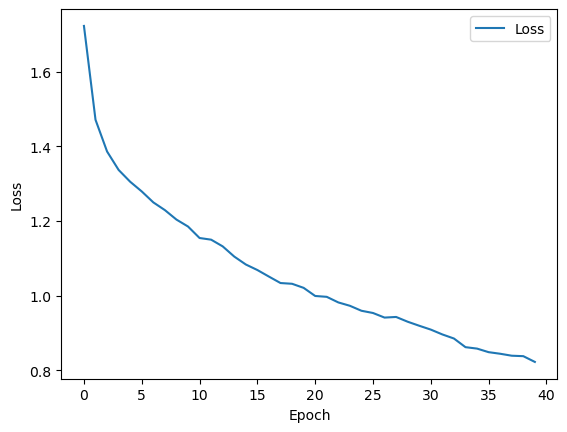

Saved PyTorch Model State to improved_conv_model.pth


In [261]:
run_experiment(improved_conv_model(droput_prob=0.3), learning_rate=1e-3, epochs=40, optimizer_name='adam', weight_decay=1e-3, save_path="improved_conv_model.pth")

We have managed to improve the performance of the model by adding normalization and reduce the variance by adding regularization.

## more complicated model
The model below is more complicated, it has 3 blocks of convolutional layers, batch normalization, pooling and dropout layers. Then one fully connected block with dropout layer.

In [262]:
class ImprovedCIFAR10CNN(nn.Module):
    def __init__(self, dropout_prob=0.25):
        super().__init__()
        
        # --------
        # Block 1: Input channels=3 -> 16
        # --------
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsamples 32x32 -> 16x16
            nn.Dropout(p=dropout_prob),
        )
        
        # --------
        # Block 2: 16 -> 32
        # --------
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsamples 16x16 -> 8x8
            nn.Dropout(p=dropout_prob),
        )

        # --------
        # Block 3: 32 -> 64
        # --------
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * 4 * 4, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # More aggressive dropout in the fully connected stage
            nn.Linear(in_features=128, out_features=10)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # Flatten before the classifier
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x
    

Epoch 1
-------------------------------
Loss: 1.622698, Accuracy: 39.9%
Epoch 2
-------------------------------
Loss: 1.267291, Accuracy: 54.4%
Epoch 3
-------------------------------
Loss: 1.120581, Accuracy: 60.3%
Epoch 4
-------------------------------
Loss: 1.032084, Accuracy: 63.7%
Epoch 5
-------------------------------
Loss: 0.956492, Accuracy: 66.6%
Epoch 6
-------------------------------
Loss: 0.913338, Accuracy: 68.3%
Epoch 7
-------------------------------
Loss: 0.865278, Accuracy: 70.2%
Epoch 8
-------------------------------
Loss: 0.841615, Accuracy: 70.9%
Epoch 9
-------------------------------
Loss: 0.802224, Accuracy: 72.5%
Epoch 10
-------------------------------
Loss: 0.783848, Accuracy: 73.3%
Epoch 11
-------------------------------
Loss: 0.771401, Accuracy: 73.7%
Epoch 12
-------------------------------
Loss: 0.753657, Accuracy: 74.4%
Epoch 13
-------------------------------
Loss: 0.741761, Accuracy: 74.8%
Epoch 14
-------------------------------
Loss: 0.720039, Acc

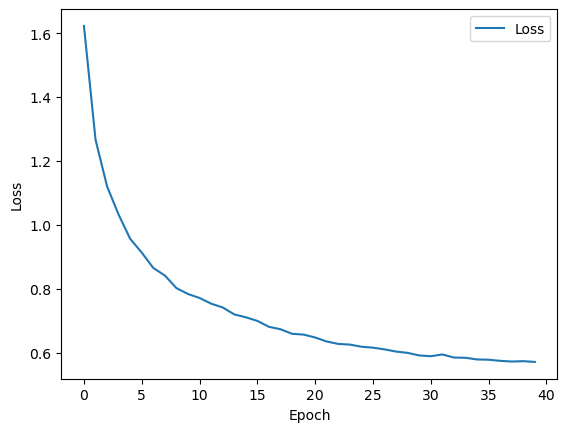

Saved PyTorch Model State to improved_cifar10_cnn.pth


In [263]:
run_experiment(ImprovedCIFAR10CNN(), learning_rate=1e-3, epochs=40, optimizer_name='adam', weight_decay=1e-3, save_path="improved_cifar10_cnn.pth")

This improved model behaves much better than the previous one, with less bias and variance, and higher accuracy.

Next we will try to improve the model by using SGD with momentum.



Epoch 1
-------------------------------
Loss: 1.991662, Accuracy: 25.4%
Epoch 2
-------------------------------
Loss: 1.617581, Accuracy: 39.3%
Epoch 3
-------------------------------
Loss: 1.484485, Accuracy: 45.1%
Epoch 4
-------------------------------
Loss: 1.393837, Accuracy: 48.9%
Epoch 5
-------------------------------
Loss: 1.313311, Accuracy: 52.3%
Epoch 6
-------------------------------
Loss: 1.236494, Accuracy: 55.4%
Epoch 7
-------------------------------
Loss: 1.177160, Accuracy: 57.8%
Epoch 8
-------------------------------
Loss: 1.133327, Accuracy: 59.5%
Epoch 9
-------------------------------
Loss: 1.087046, Accuracy: 61.2%
Epoch 10
-------------------------------
Loss: 1.054393, Accuracy: 62.5%
Epoch 11
-------------------------------
Loss: 1.022881, Accuracy: 63.7%
Epoch 12
-------------------------------
Loss: 0.996349, Accuracy: 64.5%
Epoch 13
-------------------------------
Loss: 0.971227, Accuracy: 65.7%
Epoch 14
-------------------------------
Loss: 0.951339, Acc

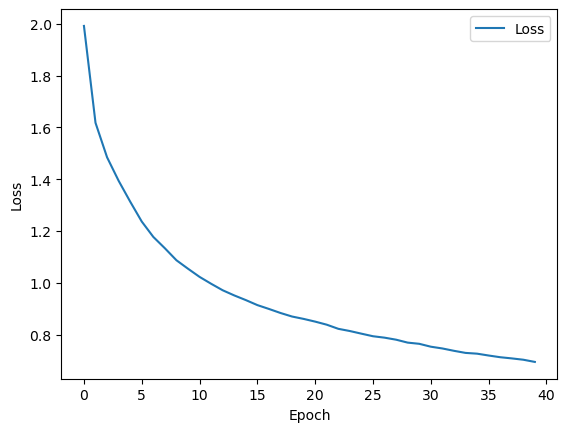

Saved PyTorch Model State to improved_cifar10_cnn_sgd_momentum.pth


In [264]:
run_experiment(ImprovedCIFAR10CNN(dropout_prob=0.25), learning_rate=1e-3, epochs=40, optimizer_name='sgd', momentum=0.9, save_path="improved_cifar10_cnn_sgd_momentum.pth")

The model with SGD with momentum has similar performance than the model with adam optimizer, and performs seems to be more prone to overfitting.

## Using a pretrained model ResNet50 model
First we will change the final output layer of the ResNet50 model to match the number of classes in CIFAR-10 dataset.

Then we will freeze the weights of the model and train only the final layer.

We will run the pretrained ResNet50 model on the dataset with similar parameters as the previous model.

Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=10, bias=True)
Epoch 1
-------------------------------
Loss: 1.820774, Accuracy: 37.9%
Epoch 2
-------------------------------
Loss: 1.574214, Accuracy: 47.0%
Epoch 3
-------------------------------
Loss: 1.507198, Accuracy: 49.0%
Epoch 4
-------------------------------
Loss: 1.466348, Accuracy: 50.2%
Epoch 5
-------------------------------
Loss: 1.436450, Accuracy: 51.2%
Epoch 6
-------------------------------
Loss: 1.412686, Accuracy: 52.0%
Epoch 7
-------------------------------
Loss: 1.392917, Accuracy: 52.6%
Epoch 8
-------------------------------
Loss: 1.375991, Accuracy: 53.1%
Epoch 9
-------------------------------
Loss: 1.361214, Accuracy: 53.6%
Epoch 10
-------------------------------
Loss: 1.348126, Accuracy: 54.0%
Epoch 11
-------------------------------
Loss: 1.336405, Accuracy: 54.4%
Epoch 12
-------------------------------
Loss: 1.325816, Accuracy: 54.7%
Epoch 13
----------------

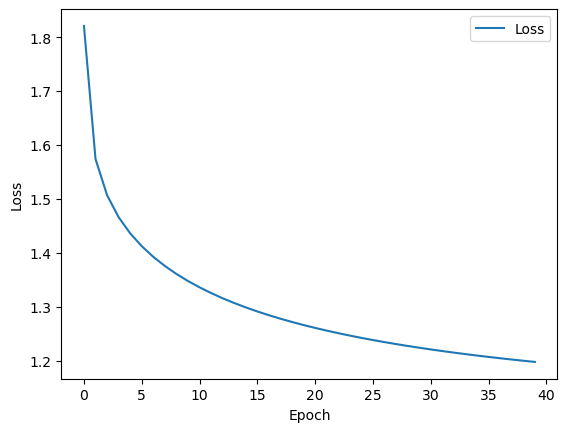

Saved PyTorch Model State to resnet50.pth


In [265]:
from torchvision import models
ResNet50 = models.resnet50(pretrained=True)

print(ResNet50.fc)
fc_in_features = ResNet50.fc.in_features
# Adjusting the last layer to match the number of classes in CIFAR-10
ResNet50.fc = nn.Linear(in_features=fc_in_features, out_features=10)
print(ResNet50.fc)

# Freeze all the weights in the model
for param in ResNet50.parameters():
    param.requires_grad = False

# Unfreeze the weights of the final layer
for param in ResNet50.fc.parameters():
    param.requires_grad = True

run_experiment(ResNet50, learning_rate=1e-3, epochs=40, optimizer_name='sgd',momentum=0.9, save_path="resnet50.pth")

Looks like the pretrained model performs worse than the last model we trained with those parameters.
probably fixable with some adjustments and trial and error.

## Running our best model - "ImprovedCIFAR10CNN" with more epochs

Epoch 1
-------------------------------
Loss: 1.807049, Accuracy: 31.3%
Epoch 2
-------------------------------
Loss: 1.520696, Accuracy: 43.4%
Epoch 3
-------------------------------
Loss: 1.382367, Accuracy: 49.2%
Epoch 4
-------------------------------
Loss: 1.289974, Accuracy: 53.1%
Epoch 5
-------------------------------
Loss: 1.212472, Accuracy: 56.4%
Epoch 6
-------------------------------
Loss: 1.137103, Accuracy: 59.5%
Epoch 7
-------------------------------
Loss: 1.086358, Accuracy: 61.3%
Epoch 8
-------------------------------
Loss: 1.042011, Accuracy: 62.8%
Epoch 9
-------------------------------
Loss: 1.008020, Accuracy: 64.3%
Epoch 10
-------------------------------
Loss: 0.980275, Accuracy: 65.5%
Epoch 11
-------------------------------
Loss: 0.945707, Accuracy: 66.7%
Epoch 12
-------------------------------
Loss: 0.919490, Accuracy: 67.8%
Epoch 13
-------------------------------
Loss: 0.895136, Accuracy: 68.6%
Epoch 14
-------------------------------
Loss: 0.873422, Acc

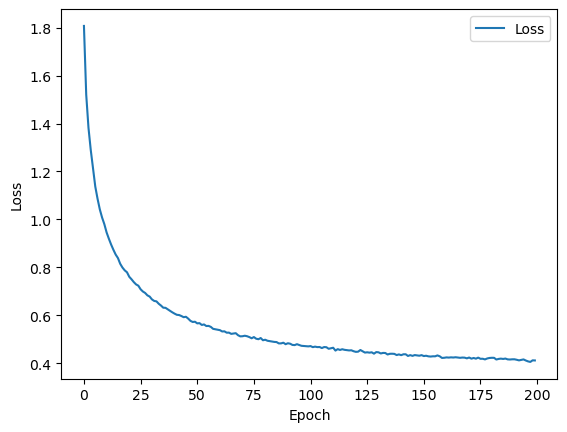

Saved PyTorch Model State to improved_cifar10_cnn_200.pth


In [167]:
run_experiment(ImprovedCIFAR10CNN(dropout_prob=0.25), learning_rate=1e-3, epochs=200, optimizer_name='sgd',momentum=0.9, weight_decay=1e-3, save_path="improved_cifar10_cnn_200.pth")

seems like the Accuracy is starting to platau around 85% accuracy and that the loss function starts to platau around epoch 150.
I will now try to implement a scheduler to lower the learning rate when we get to large epochs

### Modified train loop and experiment block to support scheduler

In [201]:
# Training loop
def train_with_scheduler(dataloader, model, loss_function, optimizer, epochs, scheduler=None):
    loss_values = []
    model.train()
    for epoch in range(epochs):
        size = len(dataloader.dataset)
        total_loss = 0
        correct = 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Compute prediction error
            pred = model(X)
            loss = loss_function(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Log the loss and accuracy
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
 
         # Getting the learning rate before stepping the scheduler
        old_lr = optimizer.param_groups[0]['lr']

        
        # Step the scheduler
        if scheduler is not None:
            scheduler.step()
            
        new_lr = optimizer.param_groups[0]['lr']
        
        if ((epoch + 1) in scheduler.milestones):
            print(f"Reached milestone at epoch {epoch+1}.")
            print(f"  LR changed from {old_lr:.6f} to {new_lr:.6f}.")           
            
        
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / size
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch}/{epochs}]Loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%")
        
    return loss_values

In [202]:
def run_experiment_with_scheduler(model, learning_rate=1e-3, epochs=5, optimizer_name='adam',
                   weight_decay=None, momentum=None, save_path=None):
    start_time = time.time()
    model = model.to(device)
    
    # Set the optimizer parameters if specified in the function call
    optimizer_params = {'lr': learning_rate}
    if weight_decay:
        optimizer_params['weight_decay'] = weight_decay
    
    # Initialize the optimizer based on the optimizer name
    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), **optimizer_params)
    elif optimizer_name.lower() == 'sgd':
        if momentum:  # Check if momentum is specified only for SGD
            optimizer_params['momentum'] = momentum
        optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
    else:
        raise ValueError("Invalid optimizer name")
    
    # Initialize the scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[50,100, 150],  # Adjust based on your total epochs
        gamma=0.1
    )
    
    # Initialize the loss function
    loss_function = nn.CrossEntropyLoss()
    
    loss_values = train_with_scheduler(
        train_dataloader, 
        model, 
        loss_function, 
        optimizer, 
        epochs, 
        scheduler=scheduler  # new argument
    )
    
    test_accuracy, test_loss = test(test_dataloader, model, loss_function)
    
    print_time_taken(start_time, time.time())
    print("Test results:")
    print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")
    
    plot_loss(loss_values)
    
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"Saved PyTorch Model State to {save_path}")


### Running my selected model with scheduler

Epoch [0/200]Loss: 1.853195, Accuracy: 29.9%
Epoch [1/200]Loss: 1.509301, Accuracy: 44.1%
Epoch [2/200]Loss: 1.360164, Accuracy: 50.4%
Epoch [3/200]Loss: 1.257054, Accuracy: 54.7%
Epoch [4/200]Loss: 1.170683, Accuracy: 57.9%
Epoch [5/200]Loss: 1.116549, Accuracy: 60.2%
Epoch [6/200]Loss: 1.066402, Accuracy: 62.0%
Epoch [7/200]Loss: 1.024887, Accuracy: 63.5%
Epoch [8/200]Loss: 0.989673, Accuracy: 65.0%
Epoch [9/200]Loss: 0.954526, Accuracy: 66.3%
Epoch [10/200]Loss: 0.924313, Accuracy: 67.5%
Epoch [11/200]Loss: 0.899148, Accuracy: 68.2%
Epoch [12/200]Loss: 0.871158, Accuracy: 69.2%
Epoch [13/200]Loss: 0.851494, Accuracy: 70.0%
Epoch [14/200]Loss: 0.837962, Accuracy: 70.6%
Epoch [15/200]Loss: 0.818227, Accuracy: 71.5%
Epoch [16/200]Loss: 0.798298, Accuracy: 72.2%
Epoch [17/200]Loss: 0.784890, Accuracy: 72.7%
Epoch [18/200]Loss: 0.769845, Accuracy: 73.2%
Epoch [19/200]Loss: 0.756971, Accuracy: 73.6%
Epoch [20/200]Loss: 0.747232, Accuracy: 73.9%
Epoch [21/200]Loss: 0.734127, Accuracy: 74.5

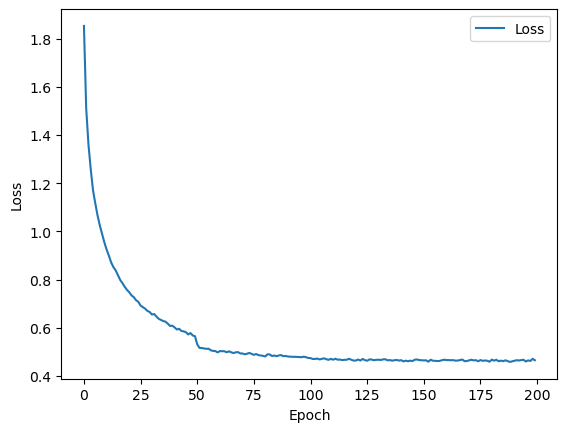

Saved PyTorch Model State to improved_cifar10_cnn_200.pth


In [203]:
run_experiment_with_scheduler(ImprovedCIFAR10CNN(dropout_prob=0.25), learning_rate=1e-3, epochs=200, optimizer_name='sgd',momentum=0.9, weight_decay=1e-3, save_path="improved_cifar10_cnn_200_with schedular.pth")

Seems like using a scheduler didn't improve the performance

## The selected model: "ImprovedCIFAR10CNN" with 200 epochs
### Copy of it's previous block:

In [ ]:
class ImprovedCIFAR10CNN(nn.Module):
    def __init__(self, dropout_prob=0.25):
        super().__init__()
        
        # --------
        # Block 1: Input channels=3 -> 16
        # --------
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsamples 32x32 -> 16x16
            nn.Dropout(p=dropout_prob),
        )
        
        # --------
        # Block 2: 16 -> 32
        # --------
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsamples 16x16 -> 8x8
            nn.Dropout(p=dropout_prob),
        )

        # --------
        # Block 3: 32 -> 64
        # --------
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=dropout_prob),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * 4 * 4, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),  # More aggressive dropout in the fully connected stage
            nn.Linear(in_features=128, out_features=10)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # Flatten before the classifier
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

Epoch 1
-------------------------------
Loss: 1.977881, Accuracy: 25.5%
Epoch 2
-------------------------------
Loss: 1.634178, Accuracy: 38.8%
Epoch 3
-------------------------------
Loss: 1.495526, Accuracy: 44.9%
Epoch 4
-------------------------------
Loss: 1.412292, Accuracy: 48.5%
Epoch 5
-------------------------------
Loss: 1.348395, Accuracy: 51.1%
Epoch 6
-------------------------------
Loss: 1.295951, Accuracy: 52.9%
Epoch 7
-------------------------------
Loss: 1.240216, Accuracy: 55.3%
Epoch 8
-------------------------------
Loss: 1.189808, Accuracy: 57.3%
Epoch 9
-------------------------------
Loss: 1.147734, Accuracy: 58.7%
Epoch 10
-------------------------------
Loss: 1.109163, Accuracy: 60.4%
Epoch 11
-------------------------------
Loss: 1.070721, Accuracy: 61.8%
Epoch 12
-------------------------------
Loss: 1.043691, Accuracy: 63.0%
Epoch 13
-------------------------------
Loss: 1.016524, Accuracy: 64.0%
Epoch 14
-------------------------------
Loss: 0.992308, Acc

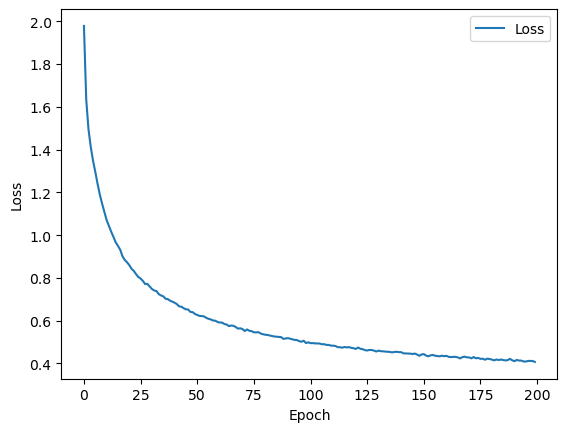

Saved PyTorch Model State to improved_cifar10_cnn_200.pth


In [267]:
run_experiment(ImprovedCIFAR10CNN(dropout_prob=0.25), learning_rate=1e-3, epochs=200, optimizer_name='sgd',momentum=0.9, weight_decay=1e-3, save_path="improved_cifar10_cnn_200.pth")

Epoch 1
-------------------------------
Loss: 1.643680, Accuracy: 38.8%
Epoch 2
-------------------------------
Loss: 1.306736, Accuracy: 52.9%
Epoch 3
-------------------------------
Loss: 1.170345, Accuracy: 58.6%
Epoch 4
-------------------------------
Loss: 1.077475, Accuracy: 62.1%
Epoch 5
-------------------------------
Loss: 1.009816, Accuracy: 64.7%
Epoch 6
-------------------------------
Loss: 0.955212, Accuracy: 66.5%
Epoch 7
-------------------------------
Loss: 0.908868, Accuracy: 68.3%
Epoch 8
-------------------------------
Loss: 0.879476, Accuracy: 70.0%
Epoch 9
-------------------------------
Loss: 0.847023, Accuracy: 70.7%
Epoch 10
-------------------------------
Loss: 0.818710, Accuracy: 71.9%
Epoch 11
-------------------------------
Loss: 0.793884, Accuracy: 72.7%
Epoch 12
-------------------------------
Loss: 0.775893, Accuracy: 73.8%
Epoch 13
-------------------------------
Loss: 0.760819, Accuracy: 74.1%
Epoch 14
-------------------------------
Loss: 0.744253, Acc

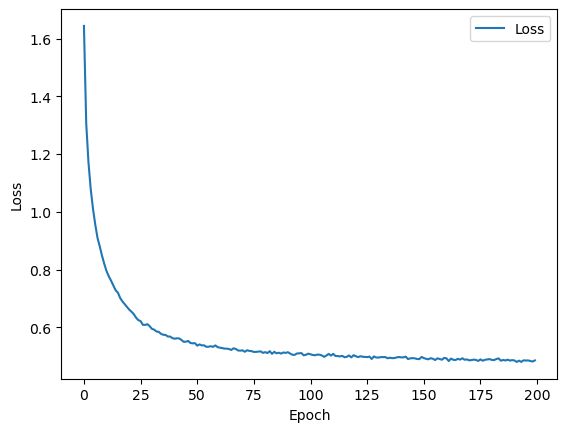

Saved PyTorch Model State to improved_cifar10_cnn_200_adam.pth


In [266]:
run_experiment(ImprovedCIFAR10CNN(), learning_rate=1e-3, epochs=200, optimizer_name='adam', weight_decay=1e-3, save_path="improved_cifar10_cnn_200_adam.pth")

# Notes
In my experiments, I focused mostly on the models architecture with some focus on the optimizers
My goal was to compare differant architectures with similar hyperparameters, so I would have less bias (in the scientific sense) between the results.
I'm positive that the models used along the way can reach better results with more fine-tuning.


# Functions Graveyard

In [168]:
'''
# Initialize the base model
start_time = time.time()
model = base_model().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

epochs = 40
loss_values = train(train_dataloader, model, loss_function, optimizer, epochs)
    
# Calculate the model accuracy on the test set, bias and variance
test_accuracy, test_loss = test(test_dataloader, model, loss_function)
bias, variance = calculate_bias_variance(model, test_dataloader, loss_function)

print(f"Time taken: {time.time() - start_time} seconds")
print("Test results:")

print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")

print( f"Bias: {bias}, Variance: {variance}")

plot_loss(loss_values)

# saving the model
torch.save(model.state_dict(), "base_model.pth")

print("Saved PyTorch Model State to base_model.pth")
'''

'\n# Initialize the base model\nstart_time = time.time()\nmodel = base_model().to(device)\n\noptimizer = torch.optim.SGD(model.parameters(), lr=1e-3)\nloss_function = nn.CrossEntropyLoss()\n\nepochs = 40\nloss_values = train(train_dataloader, model, loss_function, optimizer, epochs)\n    \n# Calculate the model accuracy on the test set, bias and variance\ntest_accuracy, test_loss = test(test_dataloader, model, loss_function)\nbias, variance = calculate_bias_variance(model, test_dataloader, loss_function)\n\nprint(f"Time taken: {time.time() - start_time} seconds")\nprint("Test results:")\n\nprint(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f}")\n\nprint( f"Bias: {bias}, Variance: {variance}")\n\nplot_loss(loss_values)\n\n# saving the model\ntorch.save(model.state_dict(), "base_model.pth")\n\nprint("Saved PyTorch Model State to base_model.pth")\n'

In [169]:
'''def calculate_bias_variance(model, dataloader, num_samples=100):
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            true_values.append(y.cpu().numpy())
            preds = []
            for _ in range(num_samples):
                preds.append(model(X).cpu().numpy())
            predictions.append(np.mean(preds, axis=0))
    
    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)
    
    # Convert true_values to one-hot encoding
    true_values_one_hot = np.eye(predictions.shape[1])[true_values]
    
    bias = np.mean((predictions - true_values_one_hot) ** 2)
    
    variance = np.mean(np.var(predictions, axis=0))
    
    return bias, variance
'''

'def calculate_bias_variance(model, dataloader, num_samples=100):\n    model.eval()\n    predictions = []\n    true_values = []\n    \n    with torch.no_grad():\n        for X, y in dataloader:\n            X, y = X.to(device), y.to(device)\n            true_values.append(y.cpu().numpy())\n            preds = []\n            for _ in range(num_samples):\n                preds.append(model(X).cpu().numpy())\n            predictions.append(np.mean(preds, axis=0))\n    \n    predictions = np.concatenate(predictions)\n    true_values = np.concatenate(true_values)\n    \n    # Convert true_values to one-hot encoding\n    true_values_one_hot = np.eye(predictions.shape[1])[true_values]\n    \n    bias = np.mean((predictions - true_values_one_hot) ** 2)\n    \n    variance = np.mean(np.var(predictions, axis=0))\n    \n    return bias, variance\n'

In [170]:
'''# Another approach to calculate bias and variance -- fixed bias
def calculate_bias_variance(model, dataloader, num_samples=100):
    model.eval()
    predictions = []
    true_values = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            true_values.append(y.cpu().numpy())
            preds = []
            for _ in range(num_samples):
                preds.append(model(X).cpu().numpy())
            predictions.append(np.mean(preds, axis=0))

    predictions = np.concatenate(predictions)
    true_values = np.concatenate(true_values)

    # Convert true_values to one-hot encoding
    true_values_one_hot = np.eye(predictions.shape[1])[true_values]

    # Calculate bias
    bias = np.mean((np.mean(predictions, axis=0) - true_values_one_hot) ** 2)

    # Calculate variance
    variance = np.mean(np.var(predictions, axis=0))

    return bias, variance
'''

'# Another approach to calculate bias and variance -- fixed bias\ndef calculate_bias_variance(model, dataloader, num_samples=100):\n    model.eval()\n    predictions = []\n    true_values = []\n\n    with torch.no_grad():\n        for X, y in dataloader:\n            X, y = X.to(device), y.to(device)\n            true_values.append(y.cpu().numpy())\n            preds = []\n            for _ in range(num_samples):\n                preds.append(model(X).cpu().numpy())\n            predictions.append(np.mean(preds, axis=0))\n\n    predictions = np.concatenate(predictions)\n    true_values = np.concatenate(true_values)\n\n    # Convert true_values to one-hot encoding\n    true_values_one_hot = np.eye(predictions.shape[1])[true_values]\n\n    # Calculate bias\n    bias = np.mean((np.mean(predictions, axis=0) - true_values_one_hot) ** 2)\n\n    # Calculate variance\n    variance = np.mean(np.var(predictions, axis=0))\n\n    return bias, variance\n'

In [171]:
'''# Another approach to calculate bias and variance -- fixed variance
def calculate_bias_variance(model, dataloader, num_samples=100):
    model.eval()
    predictions = []
    true_values = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            true_values.append(y.cpu().numpy())
            preds = []
            for _ in range(num_samples):
                preds.append(model(X).cpu().numpy())
            predictions.append(np.stack(preds, axis=0))

    predictions = np.concatenate(predictions, axis=1)
    true_values = np.concatenate(true_values)

    # Convert true_values to one-hot encoding
    true_values_one_hot = np.eye(predictions.shape[2])[true_values]

    # Calculate bias
    mean_predictions = np.mean(predictions, axis=0)
    bias = np.mean((mean_predictions - true_values_one_hot) ** 2)

    # Calculate variance
    variance = np.mean(np.var(predictions, axis=0))

    return bias, variance
'''

'# Another approach to calculate bias and variance -- fixed variance\ndef calculate_bias_variance(model, dataloader, num_samples=100):\n    model.eval()\n    predictions = []\n    true_values = []\n\n    with torch.no_grad():\n        for X, y in dataloader:\n            X, y = X.to(device), y.to(device)\n            true_values.append(y.cpu().numpy())\n            preds = []\n            for _ in range(num_samples):\n                preds.append(model(X).cpu().numpy())\n            predictions.append(np.stack(preds, axis=0))\n\n    predictions = np.concatenate(predictions, axis=1)\n    true_values = np.concatenate(true_values)\n\n    # Convert true_values to one-hot encoding\n    true_values_one_hot = np.eye(predictions.shape[2])[true_values]\n\n    # Calculate bias\n    mean_predictions = np.mean(predictions, axis=0)\n    bias = np.mean((mean_predictions - true_values_one_hot) ** 2)\n\n    # Calculate variance\n    variance = np.mean(np.var(predictions, axis=0))\n\n    return bias, v